In [1]:
import pandas as pd
import numpy as np
import mne
from sklearn.preprocessing import scale
from scipy.signal import hilbert
import pywt
import matplotlib.pyplot as plt

In [2]:
file_path = 'Original_Data.xlsx'
sfreq = 512  # Hz
ecbl_df = pd.read_excel(file_path, sheet_name='ECBL')
eobl_df = pd.read_excel(file_path, sheet_name='EOBL')
channel_names = ecbl_df.columns.tolist()

# Problem Statements: - 

#### 1. Alpha Spindle Count Comparison:Count the total number of alpha spindles in the sheets labelled ECBL and EOBL, then compare the counts to determine the difference.

In [3]:
def df_to_raw(df, sfreq, ch_names):
    data_scaled = scale(df.values.T)  # shape (n_channels, n_times)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(data_scaled, info)
    return raw

raw_ecbl = df_to_raw(ecbl_df, sfreq, channel_names)
raw_eobl = df_to_raw(eobl_df, sfreq, channel_names)

raw_ecbl.save("ECBL_raw.fif", overwrite=True)
raw_eobl.save("EOBL_raw.fif", overwrite=True)

ecbl_df.to_csv("ECBL_data.csv", index=False)
eobl_df.to_csv("EOBL_data.csv", index=False)

Creating RawArray with float64 data, n_channels=31, n_times=76001
    Range : 0 ... 76000 =      0.000 ...   148.438 secs
Ready.
Creating RawArray with float64 data, n_channels=31, n_times=76001
    Range : 0 ... 76000 =      0.000 ...   148.438 secs
Ready.
Writing d:\EEG_Assignment\ECBL_raw.fif
Closing d:\EEG_Assignment\ECBL_raw.fif
[done]
Writing d:\EEG_Assignment\EOBL_raw.fif
Closing d:\EEG_Assignment\EOBL_raw.fif
[done]


In [4]:
def apply_ica(raw):
    ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=500)
    ica.fit(raw)
    raw_ica = ica.apply(raw.copy())
    return raw_ica 
raw_ecbl_ica = apply_ica(raw_ecbl)
raw_eobl_ica = apply_ica(raw_eobl)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components


C:\Users\Mahboob Alam\AppData\Local\Temp\ipykernel_1872\174947257.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 31 PCA components
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components


C:\Users\Mahboob Alam\AppData\Local\Temp\ipykernel_1872\174947257.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 31 PCA components


In [5]:
def bandpass(raw, l_freq=8, h_freq=13):
    return raw.copy().filter(l_freq=l_freq, h_freq=h_freq)

raw_ecbl_alpha = bandpass(raw_ecbl_ica)
raw_eobl_alpha = bandpass(raw_eobl_ica)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 845 samples (1.650 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [6]:
def detect_spindles(raw, channel='Pz', threshold_factor=2.5, min_duration=0.5):
    signal = raw.get_data(picks=channel)[0]
    
    envelope = np.abs(hilbert(signal))
    threshold = threshold_factor * np.std(envelope)

    above = envelope > threshold
    count, dur = 0, 0
    for a in above:
        if a:
            dur += 1
        elif dur > 0:
            if dur / sfreq >= min_duration:
                count += 1
            dur = 0
    return count

In [7]:
channel = 'Pz'  
ecbl_count = detect_spindles(raw_ecbl_alpha, channel)
eobl_count = detect_spindles(raw_eobl_alpha, channel)

In [8]:
print(f"Alpha Spindle Count in ECBL: {ecbl_count}")
print(f"Alpha Spindle Count in EOBL: {eobl_count}")
print(f"Difference: {abs(ecbl_count - eobl_count)}")

Alpha Spindle Count in ECBL: 14
Alpha Spindle Count in EOBL: 0
Difference: 14


In [9]:
def plot_wavelet(signal, title='Wavelet Scaleogram', scales=np.arange(1, 128), wavelet='morl'):
    coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/sfreq)
    plt.figure(figsize=(12, 6))
    plt.imshow(np.abs(coefs), extent=[0, len(signal)/sfreq, scales[-1], scales[0]], 
               cmap='jet', aspect='auto')
    plt.title(title)
    plt.ylabel("Scale")
    plt.xlabel("Time (s)")
    plt.colorbar(label="Amplitude")
    plt.show()

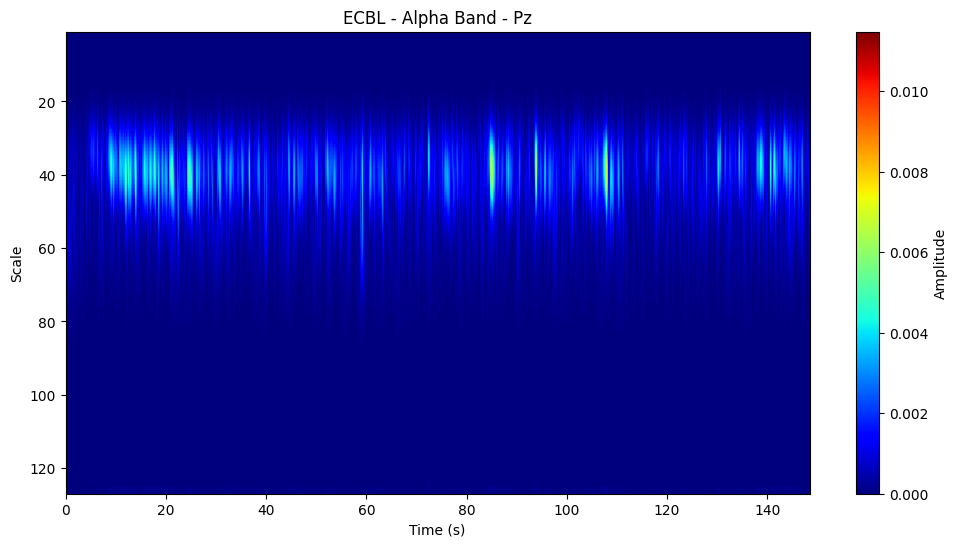

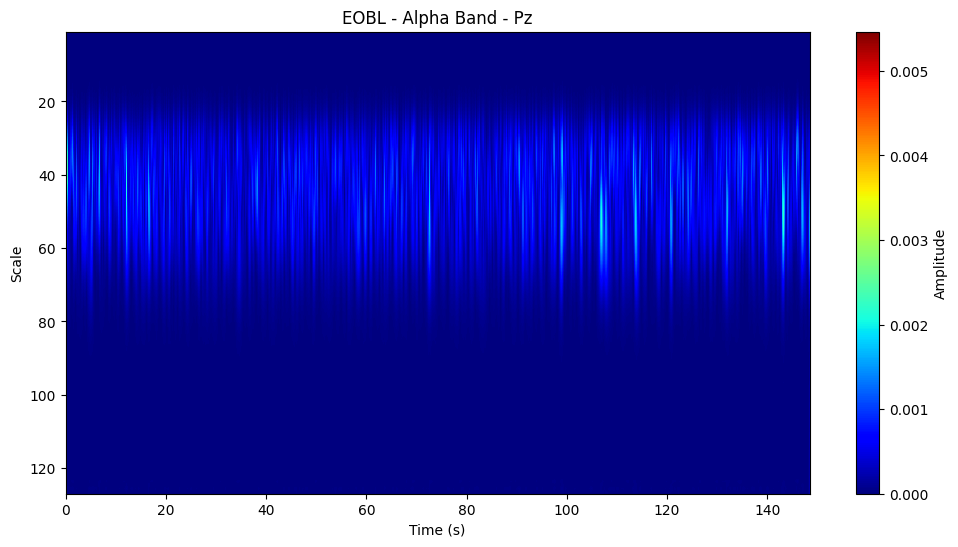

In [10]:
plot_wavelet(raw_ecbl_alpha.get_data(picks=channel)[0], title='ECBL - Alpha Band - Pz')
plot_wavelet(raw_eobl_alpha.get_data(picks=channel)[0], title='EOBL - Alpha Band - Pz')

#### 2. Electrode-wise Alpha Spindle Count Comparison: For each electrode, count the number of alpha spindles in both ECBL and EOBL sheets. Compare the counts side by side for each electrode to highlight the differences.

In [11]:
def electrode_wise_spindles(raw_ecbl, raw_eobl, threshold_factor=2.5, min_duration=0.5):
    counts = []
    for ch in raw_ecbl.ch_names:
        ecbl_cnt = detect_spindles(raw_ecbl, ch, threshold_factor, min_duration)
        eobl_cnt = detect_spindles(raw_eobl, ch, threshold_factor, min_duration)
        diff = ecbl_cnt - eobl_cnt
        counts.append([ch, ecbl_cnt, eobl_cnt, diff])
    return pd.DataFrame(counts, columns=["Electrode", "ECBL Count", "EOBL Count", "Difference"])

spindle_comparison_df = electrode_wise_spindles(raw_ecbl_alpha, raw_eobl_alpha)

print(spindle_comparison_df)

spindle_comparison_df.to_csv("Alpha_Spindle_Electrode_Comparison.csv", index=False)

   Electrode  ECBL Count  EOBL Count  Difference
0         C3           0           0           0
1         C4          14           0          14
2        CP1          11           0          11
3        CP2          10           0          10
4        CP5          12           1          11
5        CP6           2           0           2
6         F3          12           0          12
7         F4          10           0          10
8         F7           5           0           5
9         F8           7           0           7
10        Fz          12           0          12
11       FC1          17           0          17
12       FC2          12           0          12
13       FC5           6           0           6
14       FC6           9           1           8
15       Fp1           7           0           7
16       Fp2           4           0           4
17       FT9           5           1           4
18      FT10           7           0           7
19        O1        

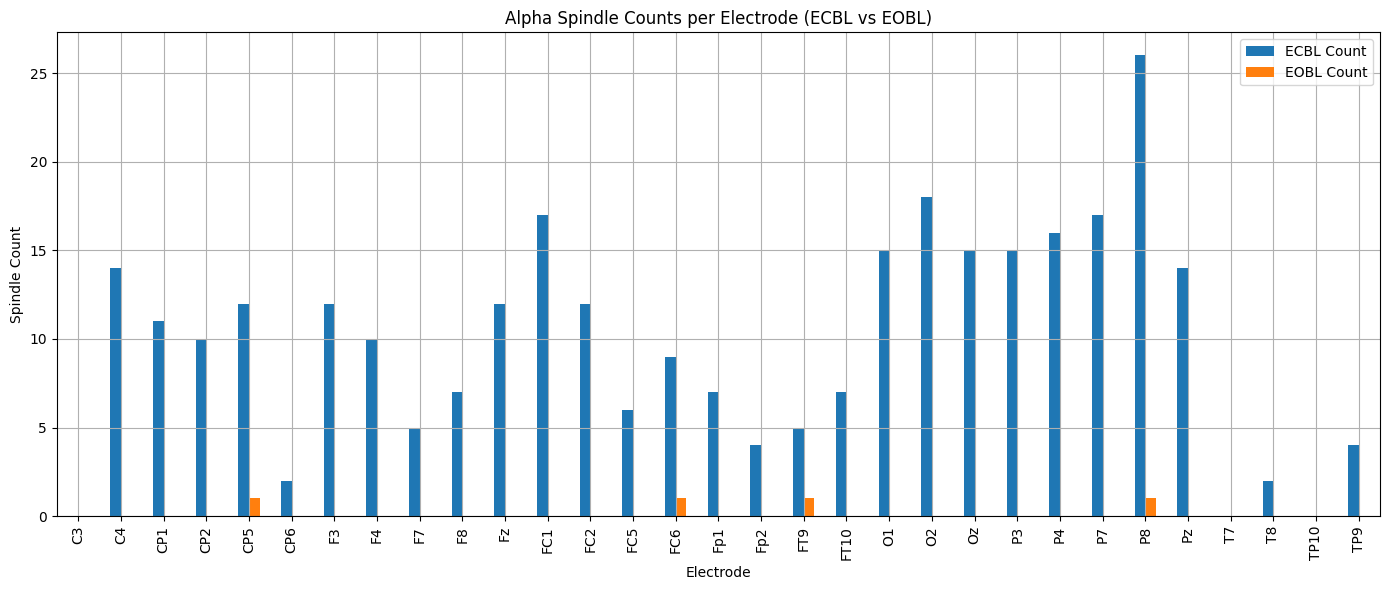

In [12]:
spindle_comparison_df.set_index("Electrode")[["ECBL Count", "EOBL Count"]].plot(
    kind='bar', figsize=(14, 6), title="Alpha Spindle Counts per Electrode (ECBL vs EOBL)"
)
plt.ylabel("Spindle Count")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3. Wavelet Transform (Scaleogram) and Spindle Visualization: Calculate the Scaleogram (wavelet transform coefficients) for a single electrode and for the complete dataset. Visualize the Scaleogram alongside the spindle activity on the same time scale.

In [13]:
def compute_wavelet(signal, sfreq, wavelet='morl', max_scale=128):
    scales = np.arange(1, max_scale)
    coefs, freqs = pywt.cwt(signal, scales, wavelet, 1/sfreq)
    return coefs, freqs

def plot_scaleogram_with_spindles(signal, spindle_mask, sfreq, title='Scaleogram + Spindles'):
    coefs, freqs = compute_wavelet(signal, sfreq)
    time = np.arange(len(signal)) / sfreq

    plt.figure(figsize=(14, 6))
    plt.imshow(np.abs(coefs), extent=[time[0], time[-1], freqs[-1], freqs[0]],
               cmap='jet', aspect='auto')
    plt.colorbar(label='Amplitude')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    for i in range(len(spindle_mask)):
        if spindle_mask[i] and (i == 0 or not spindle_mask[i - 1]):
            start = i
        if spindle_mask[i] and (i == len(spindle_mask) - 1 or not spindle_mask[i + 1]):
            end = i
            plt.axvspan(start / sfreq, end / sfreq, color='white', alpha=0.3)

    plt.tight_layout()
    plt.show()


In [14]:
def get_spindle_mask(signal, sfreq, threshold_factor=2.5):
    envelope = np.abs(hilbert(signal))
    threshold = threshold_factor * np.std(envelope)
    return envelope > threshold


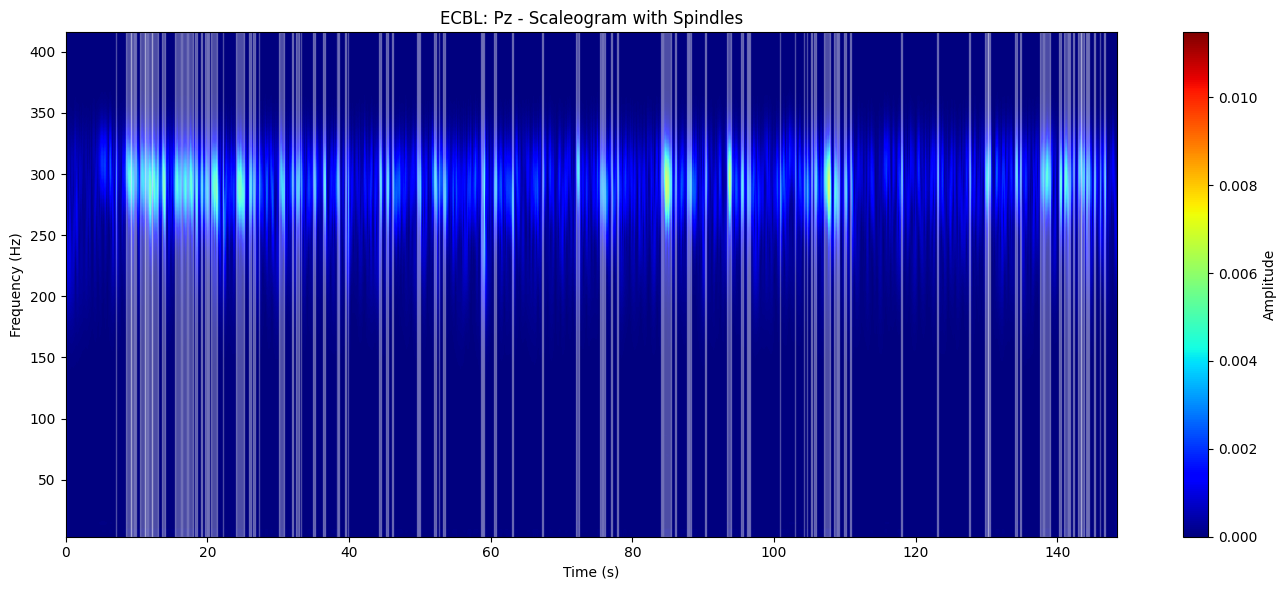

In [15]:
raw = raw_ecbl_alpha  # or raw_eobl_alpha
channel = 'Pz'

signal = raw.get_data(picks=channel)[0]
spindle_mask = get_spindle_mask(signal, sfreq)

plot_scaleogram_with_spindles(signal, spindle_mask, sfreq,
                              title=f"ECBL: {channel} - Scaleogram with Spindles")


In [16]:
def plot_avg_wavelet_power(raw, sfreq):
    powers = []
    for ch in raw.ch_names:
        signal = raw.get_data(picks=ch)[0]
        coefs, freqs = compute_wavelet(signal, sfreq)
        power = np.mean(np.abs(coefs), axis=0)  # Avg over scales
        powers.append(power)

    avg_power = np.mean(np.array(powers), axis=0)
    time = np.arange(len(avg_power)) / sfreq

    plt.figure(figsize=(12, 4))
    plt.plot(time, avg_power)
    plt.title("Average Wavelet Power Across Electrodes")
    plt.xlabel("Time (s)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


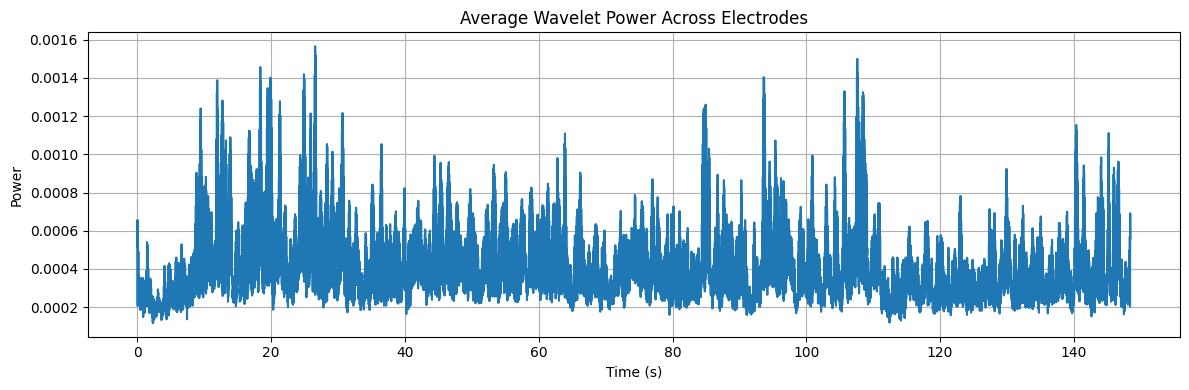

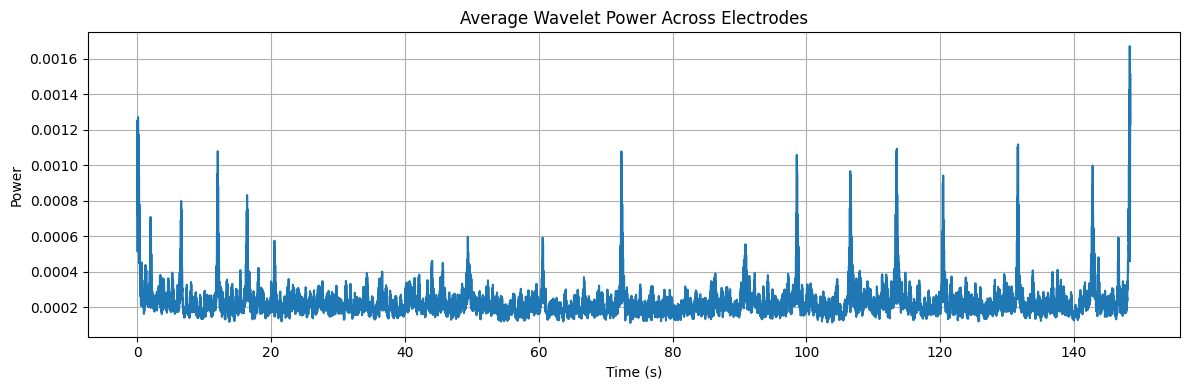

In [17]:
plot_avg_wavelet_power(raw_ecbl_alpha, sfreq)  # For ECBL
plot_avg_wavelet_power(raw_eobl_alpha, sfreq)  # For EOBL

#### 4. Epoch-based Visualization and Spindle Counting: Divide the complete dataset into 10-second epochs. For each epoch, visualize the spindles and the corresponding Scaleogram, while also counting the total number of spindles within each epoch.

In [18]:
def epoch_signal(signal, epoch_length_sec, sfreq):
    samples_per_epoch = int(epoch_length_sec * sfreq)
    num_epochs = len(signal) // samples_per_epoch
    return np.array_split(signal[:num_epochs * samples_per_epoch], num_epochs)

In [19]:
def count_spindles_in_epoch(epoch, sfreq, threshold_factor=2.5, min_duration=0.5):
    envelope = np.abs(hilbert(epoch))
    threshold = threshold_factor * np.std(envelope)
    above_thresh = envelope > threshold

    spindle_count = 0
    duration_samples = int(min_duration * sfreq)
    i = 0
    while i < len(above_thresh):
        if above_thresh[i]:
            start = i
            while i < len(above_thresh) and above_thresh[i]:
                i += 1
            if (i - start) >= duration_samples:
                spindle_count += 1
        else:
            i += 1
    return spindle_count, above_thresh

In [20]:
def plot_epoch_scaleogram(epoch, spindle_mask, sfreq, epoch_idx):
    coefs, freqs = compute_wavelet(epoch, sfreq)
    time = np.arange(len(epoch)) / sfreq

    plt.figure(figsize=(14, 5))
    plt.imshow(np.abs(coefs), extent=[time[0], time[-1], freqs[-1], freqs[0]],
               cmap='jet', aspect='auto')
    plt.colorbar(label='Amplitude')
    plt.title(f"Epoch {epoch_idx+1}: Scaleogram + Spindle Overlay")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")


    for i in range(len(spindle_mask)):
        if spindle_mask[i] and (i == 0 or not spindle_mask[i - 1]):
            start = i
        if spindle_mask[i] and (i == len(spindle_mask) - 1 or not spindle_mask[i + 1]):
            end = i
            plt.axvspan(start / sfreq, end / sfreq, color='white', alpha=0.3)

    plt.tight_layout()
    plt.show()


In [21]:
def epoch_analysis(raw, channel='Pz', epoch_duration=10):
    sfreq = int(raw.info['sfreq'])
    signal = raw.get_data(picks=channel)[0]
    epochs = epoch_signal(signal, epoch_duration, sfreq)
    
    spindle_counts = []

    for idx, epoch in enumerate(epochs):
        count, spindle_mask = count_spindles_in_epoch(epoch, sfreq)
        spindle_counts.append(count)
        print(f"Epoch {idx+1}: {count} spindles")
        plot_epoch_scaleogram(epoch, spindle_mask, sfreq, idx)

    
    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(1, len(spindle_counts)+1), spindle_counts)
    plt.xlabel("Epoch Number")
    plt.ylabel("Spindle Count")
    plt.title(f"Spindle Count per 10-second Epoch - Channel: {channel}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return spindle_counts


Epoch 1: 1 spindles


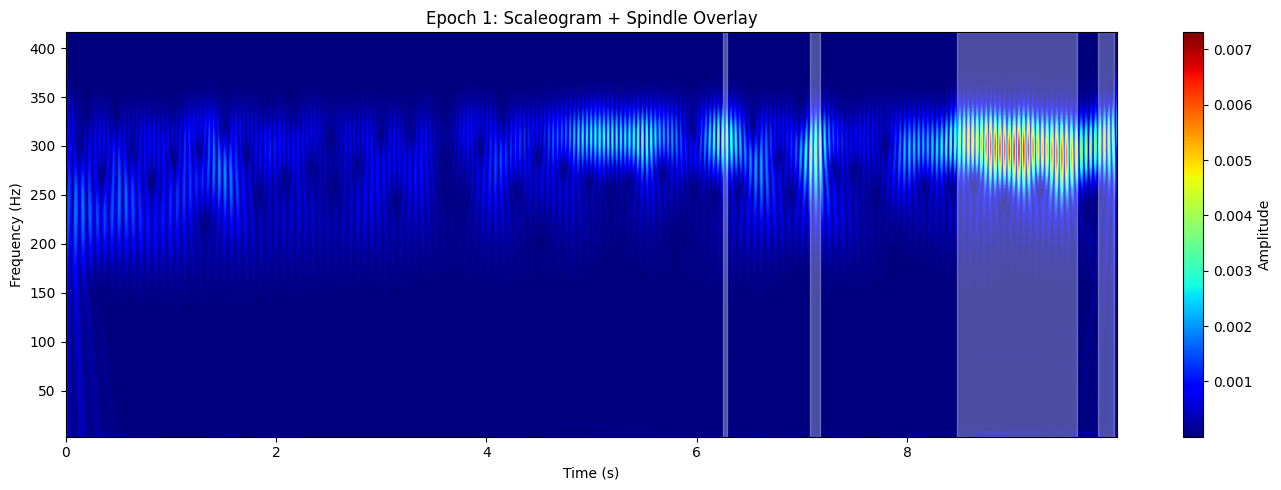

Epoch 2: 5 spindles


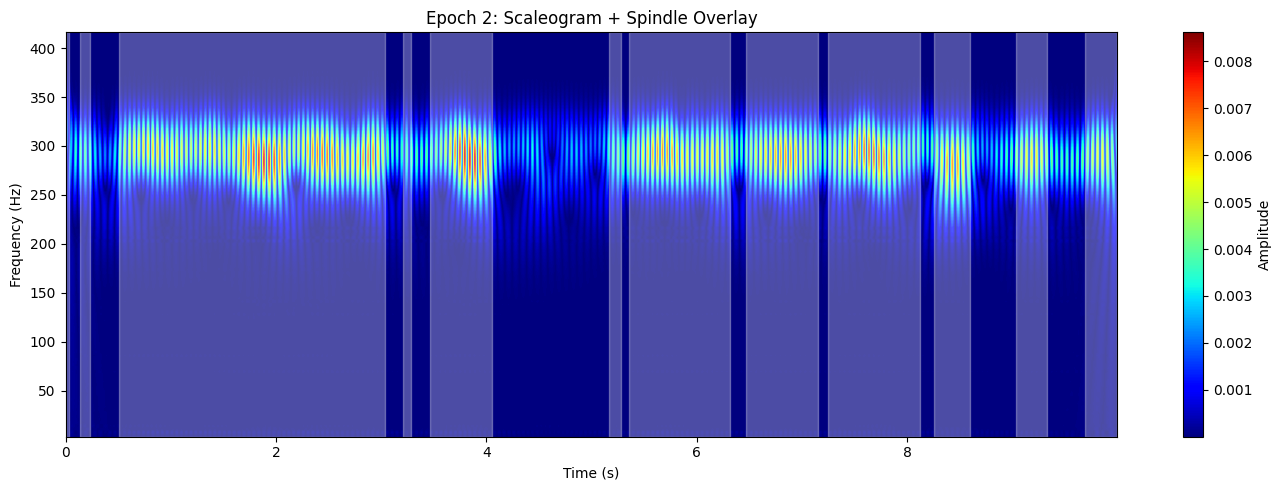

Epoch 3: 2 spindles


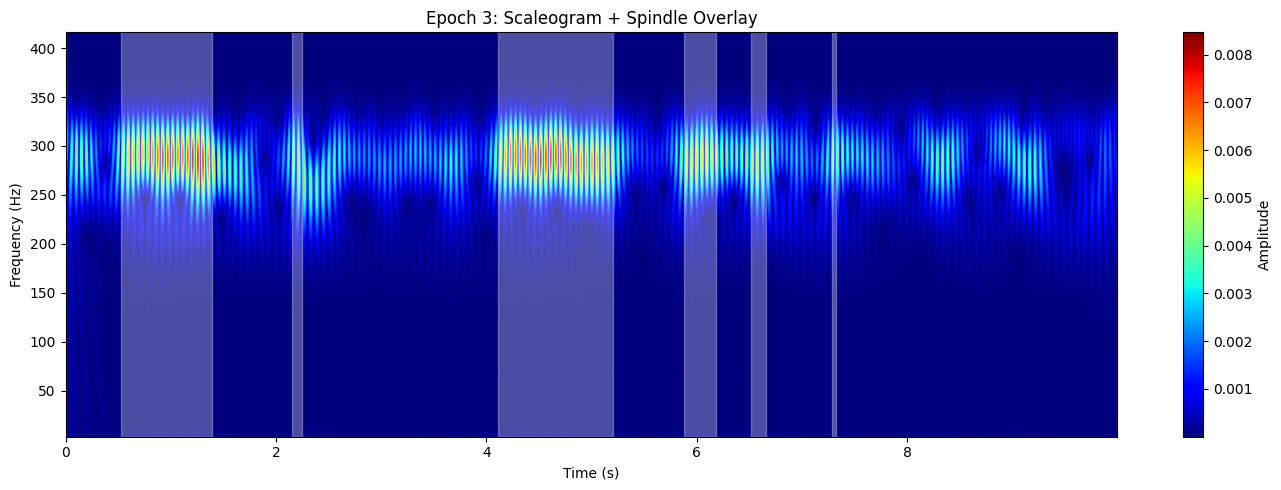

Epoch 4: 2 spindles


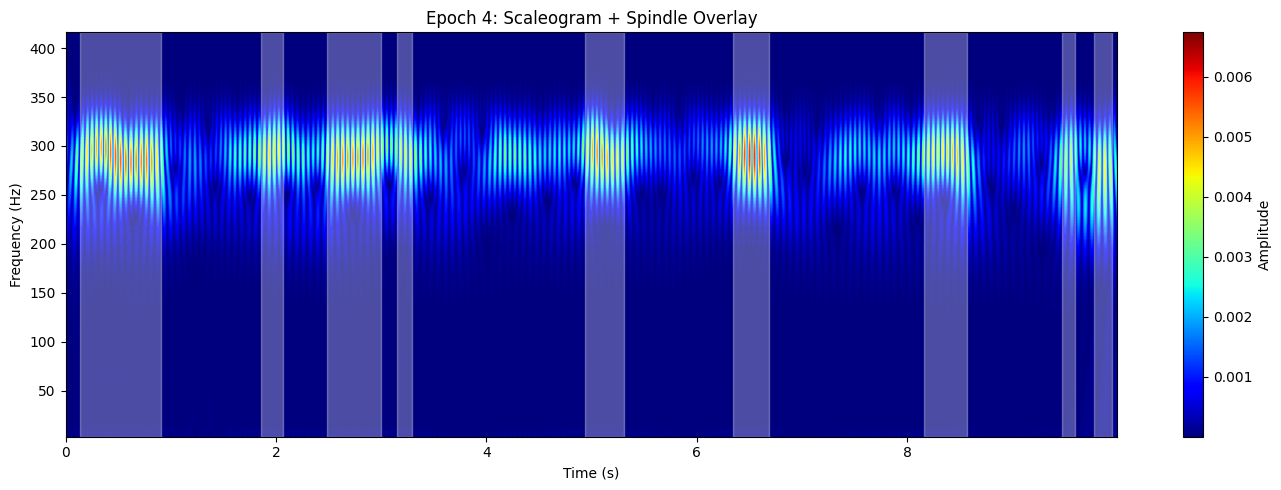

Epoch 5: 0 spindles


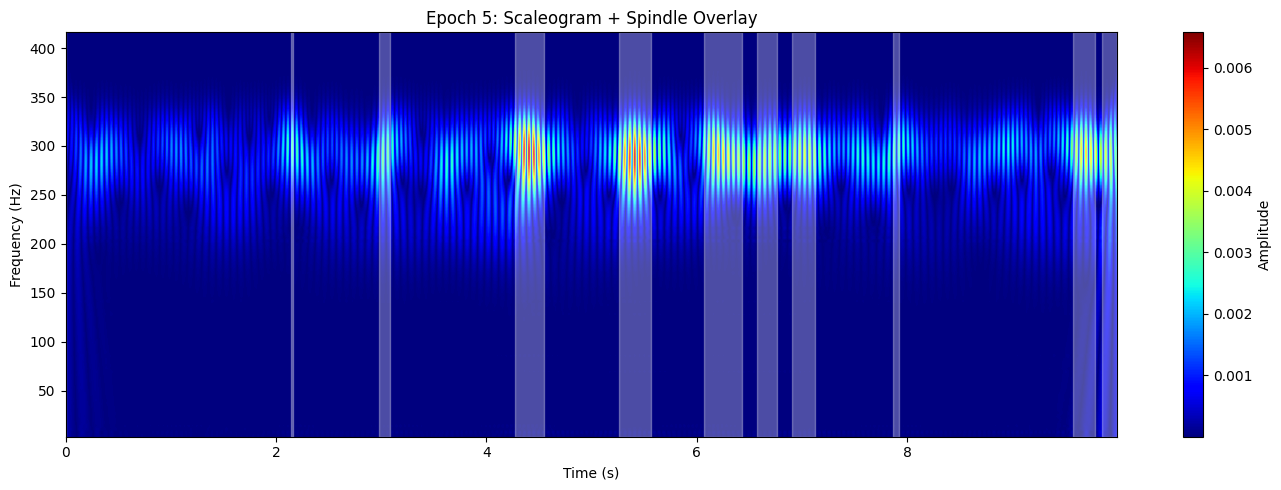

Epoch 6: 1 spindles


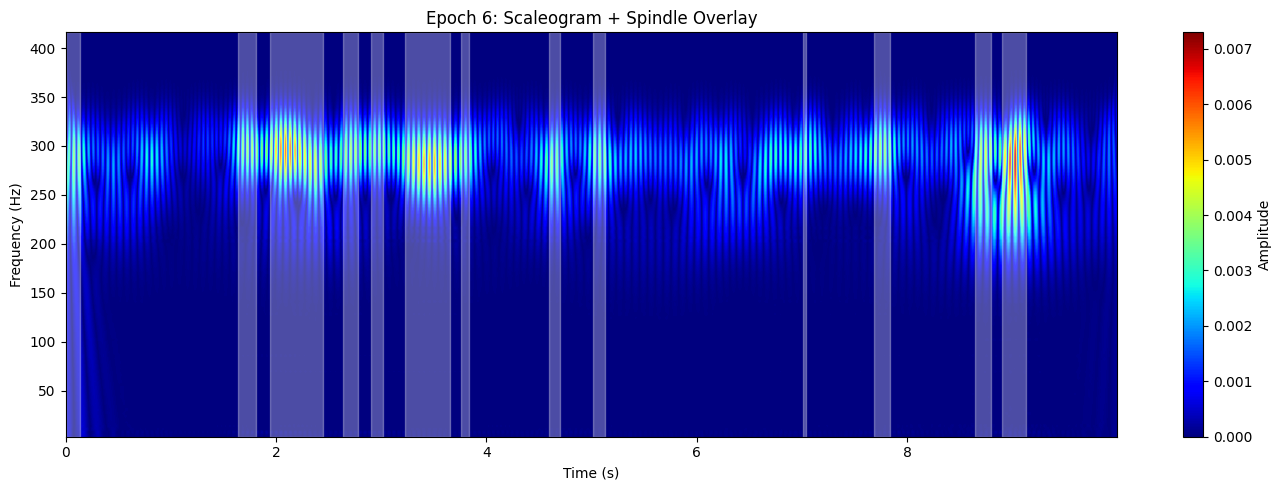

Epoch 7: 1 spindles


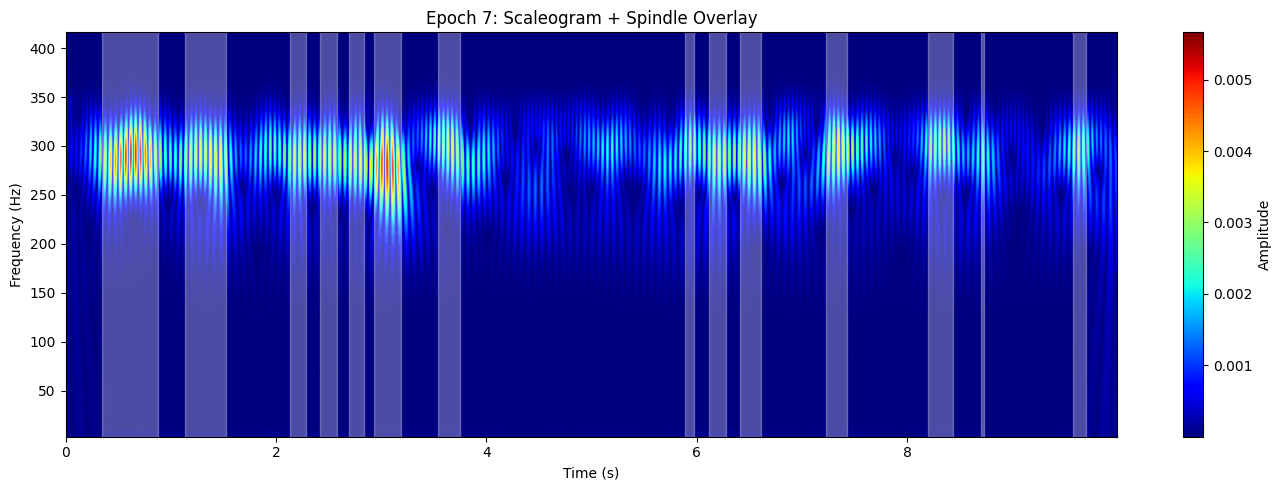

Epoch 8: 1 spindles


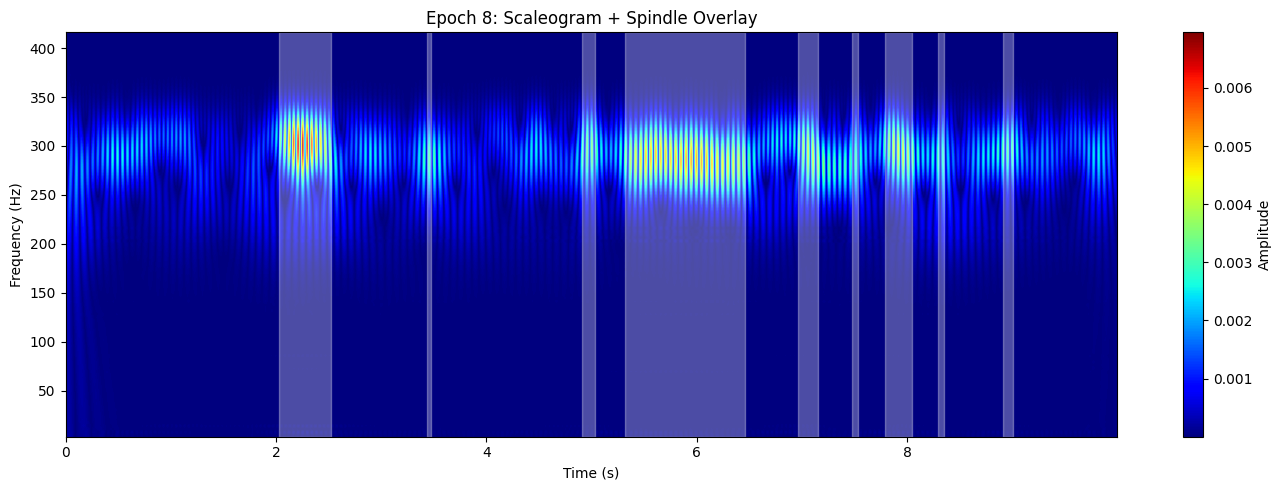

Epoch 9: 1 spindles


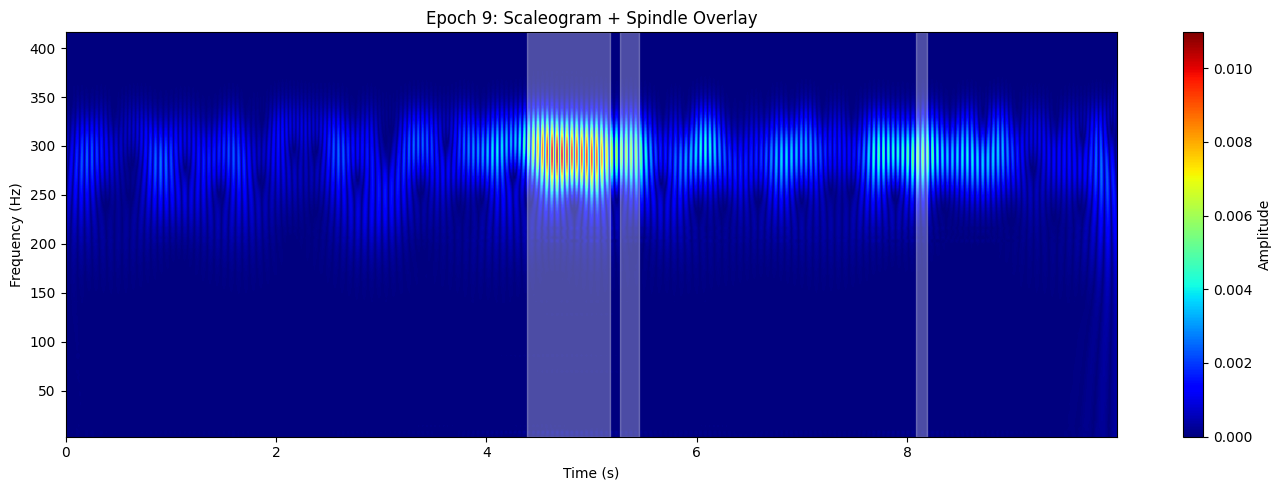

Epoch 10: 0 spindles


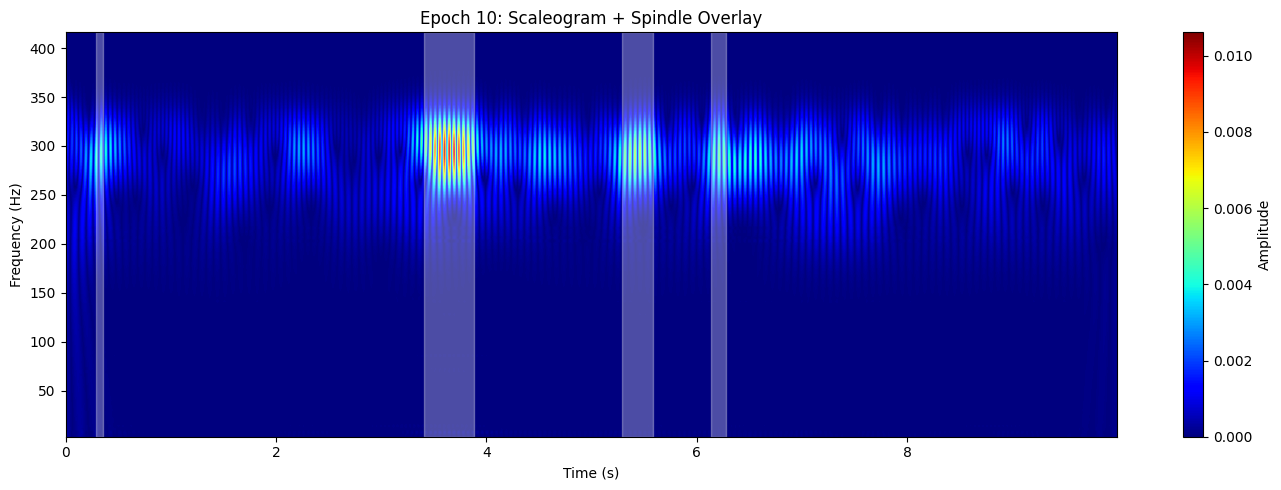

Epoch 11: 1 spindles


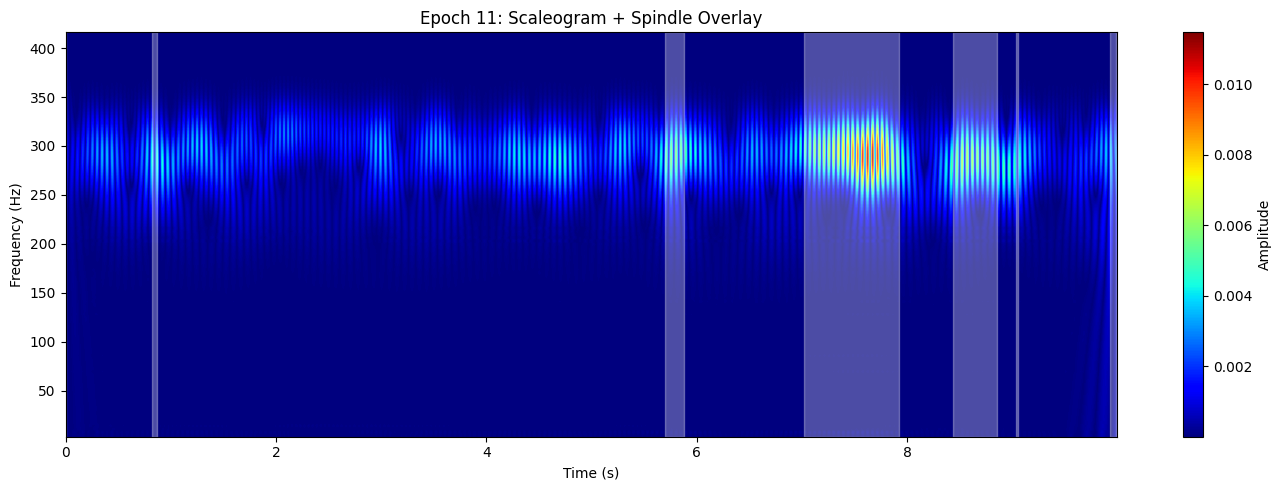

Epoch 12: 0 spindles


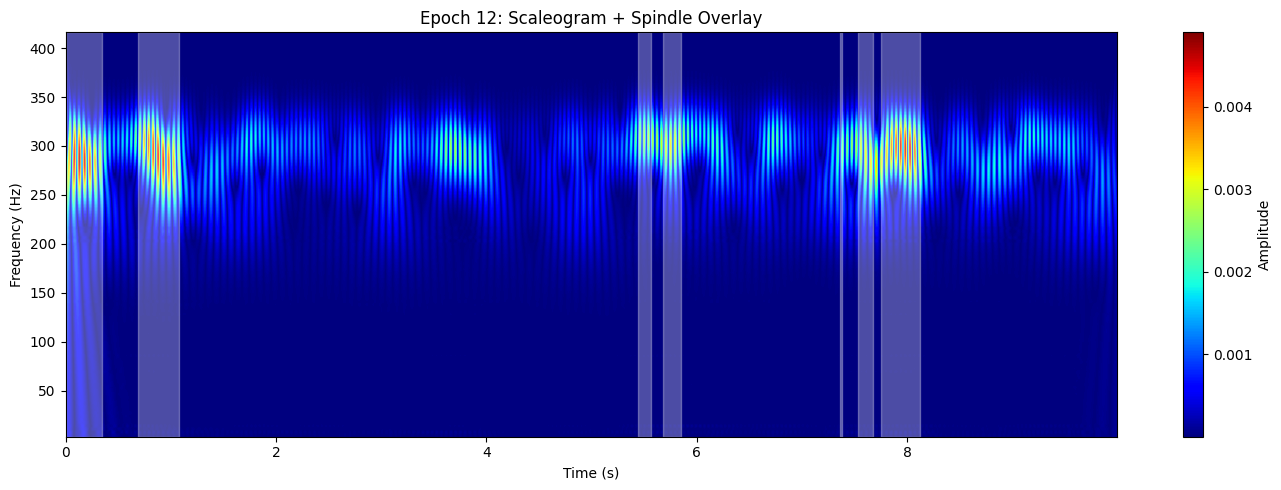

Epoch 13: 0 spindles


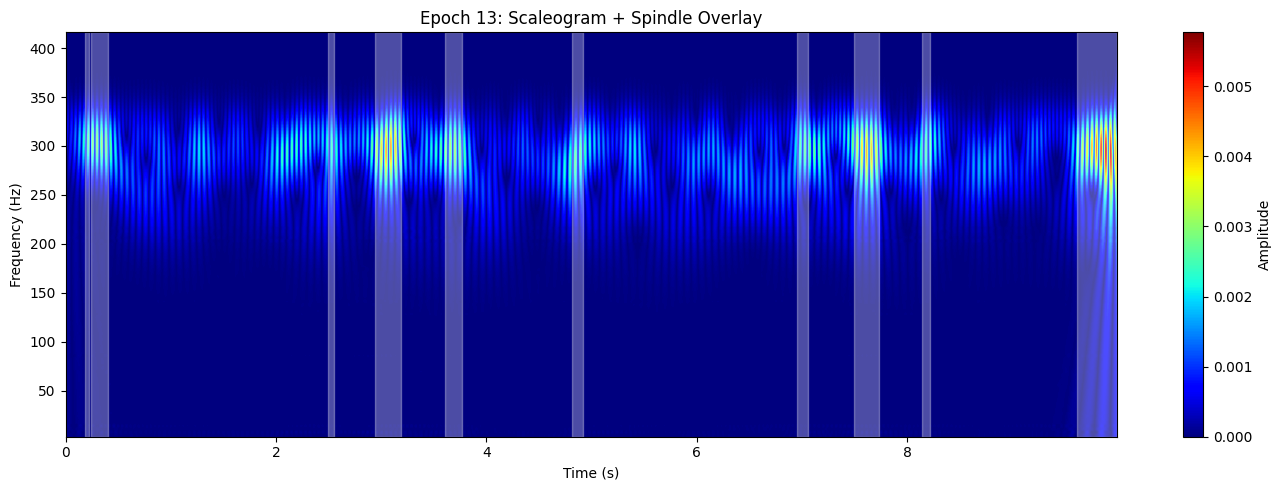

Epoch 14: 1 spindles


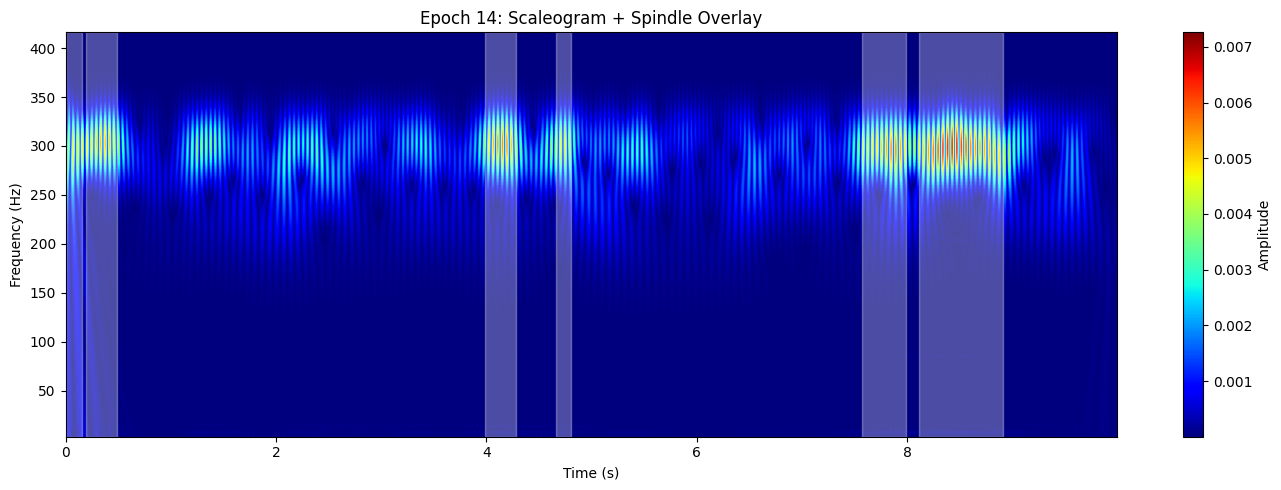

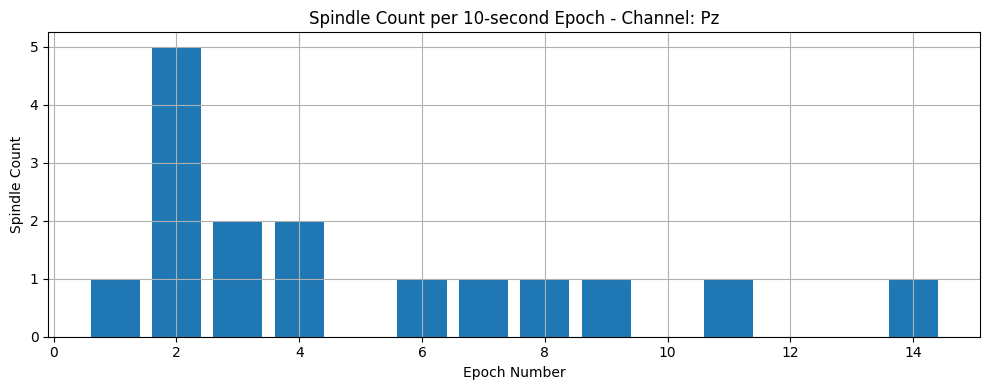

In [22]:
epoch_spindle_counts = epoch_analysis(raw_ecbl_alpha, channel='Pz', epoch_duration=10)